In [3]:
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()


# Used code from the lectures to help with the assignment.

22/10/13 22:11:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


### Q1

In [4]:
from pyspark import SparkFiles

col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","classes","difficulty_level"]

#print (col_names.tolist())


df = spark.read.csv("KDDTrain+.txt", header=False, inferSchema= True).toDF(*col_names)

df_test = spark.read.csv("KDDTest+.txt", header=False, inferSchema= True).toDF(*col_names)
# If you want to read file on the filesystem, use spark.read.csv(fileLocation, header=False, inferSchema=True)

In [5]:
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="bigdata"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "NSLKDD"


df.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

df_test.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", "NSLKDD_Test")\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()


22/10/13 22:12:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
df_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_test_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", "NSLKDD_Test")\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df_read.show(1, vertical=True)
df_test_read.show(1, vertical=True)

-RECORD 0-----------------------------
 duration                    | 0      
 protocol_type               | tcp    
 service                     | http   
 flag                        | SF     
 src_bytes                   | 277    
 dst_bytes                   | 330    
 land                        | 0      
 wrong_fragment              | 0      
 urgent                      | 0      
 hot                         | 0      
 num_failed_logins           | 0      
 logged_in                   | 1      
 num_compromised             | 0      
 root_shell                  | 0      
 su_attempted                | 0      
 num_root                    | 0      
 num_file_creations          | 0      
 num_shells                  | 0      
 num_access_files            | 0      
 num_outbound_cmds           | 0      
 is_host_login               | 0      
 is_guest_login              | 0      
 count                       | 7      
 srv_count                   | 7      
 serror_rate             

### Q2

In [ ]:
# Kafka listener is being run in a separate notebook.

In [170]:
#Important Imports
import pandas as pd 
#import findspark
#findspark.init()
#findspark.find()
import pyspark
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession

appName = "Twitter Real-time Analytics via Kafka and Spark"
master = "local"
conf = pyspark.SparkConf().set('spark.driver.host','127.0.0.1').setAppName(appName).setMaster(master)
sc = SparkContext.getOrCreate(conf=conf)

# If you need to use SQL context, you need to initialize it here.
#sqlContext = SQLContext(sc)

spark = SparkSession.builder \
    .appName("Twitter spark") \
        .getOrCreate()

sc

22/10/16 21:30:44 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


<SparkContext master=local[*] appName=PySparkShell>

In [172]:
from kafka import KafkaConsumer
import json

topic_name = 'twitter'

kafka_consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=['localhost:9092'],
    auto_offset_reset='latest',
    enable_auto_commit=True,
    auto_commit_interval_ms =  5000,
    fetch_max_bytes = 128,
    max_poll_records = 100,
    value_deserializer=lambda x: x.decode('utf-8'))

In [223]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
streamed_data = None
i = 0

for message in kafka_consumer:
    # Read the tweet from the topic
    data = [message.value]
    tweet = spark.createDataFrame(data,"string")
    # clean the tweet and extract the hashtag! 
    # Notice I'm picking one tweet at a time in a separate dataframe to avoid too-large dataframes
    # explode() returns a new row for each element in the given array or map.
    #alias() returns this column aliased with a new name or names

    if streamed_data is None:
        streamed_data = tweet.withColumn('word', explode(split(col('value'), '[ \n\t]'))) \
                    .groupBy('word') \
                    .count() \
                    .sort('count', ascending=False)
    else:
        streamed_data = streamed_data.union(tweet.withColumn('word', explode(split(col('value'), '[ \n\t]'))) \
                    .groupBy('word') \
                    .count() \
                    .sort('count', ascending=False)
                    .filter(~col('word').contains('#')))
    
    streamed_data.show()


+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows

+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                w

+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



+--------------------+-----+
|                word|count|
+--------------------+-----+
|              LFG!!!|    1|
|                 not|    1|
|             because|    1|
|                 can|    1|
|                body|    1|
|https://t.co/RIPh...|    1|
|                with|    1|
|               these|    1|
|              enough|    1|
|                worm|    1|
|                have|    1|
|                 You|    1|
|               never|    1|
|                  up|    1|
|                  of|    1|
|              picked|    1|
|                Just|    1|
|                  😏|    1|
|                   a|    1|
|                this|    1|
+--------------------+-----+
only showing top 20 rows



ERROR:root:KeyboardInterrupt while sending command.][Stage 16201:>(0 + 0) / 8]
Traceback (most recent call last):
  File "/opt/Homebrew/Cellar/apache-spark/3.3.0/libexec/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/opt/Homebrew/Cellar/apache-spark/3.3.0/libexec/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/Users/abuitano/miniforge3/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [224]:
streamed_data = streamed_data.select(lower('word').alias('word'), 'count')

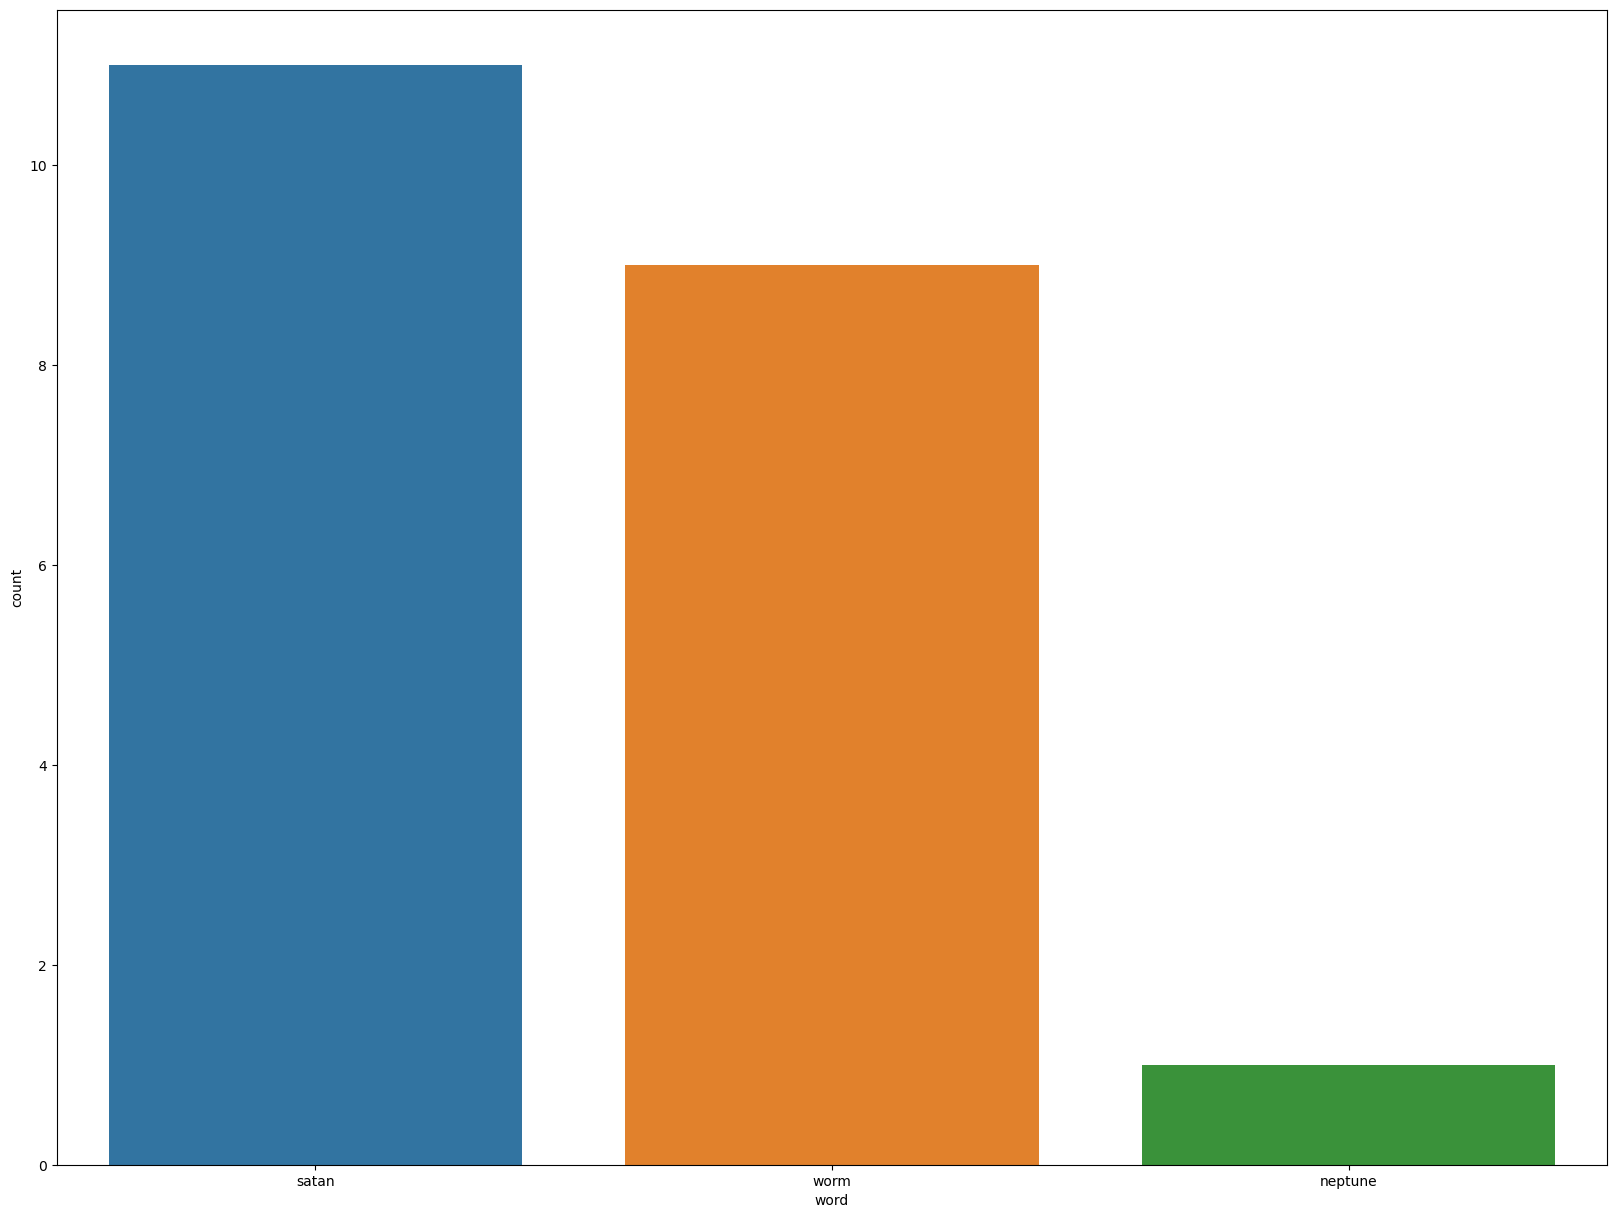

In [227]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

# Looking for the most common word within the attacks that were searched for and showing a histogram.
attacks = ["neptune", "worm", "rootkit", "satan", "smurf"]
top_5_dataframes = streamed_data.filter(streamed_data.word.isin(attacks)).groupBy("word").count().sort("count",ascending=False).limit(5).toPandas()
plt.figure( figsize = ( 20, 15 ) )
sns.barplot( x="word", y="count", data=top_5_dataframes)
plt.show()

### Q3

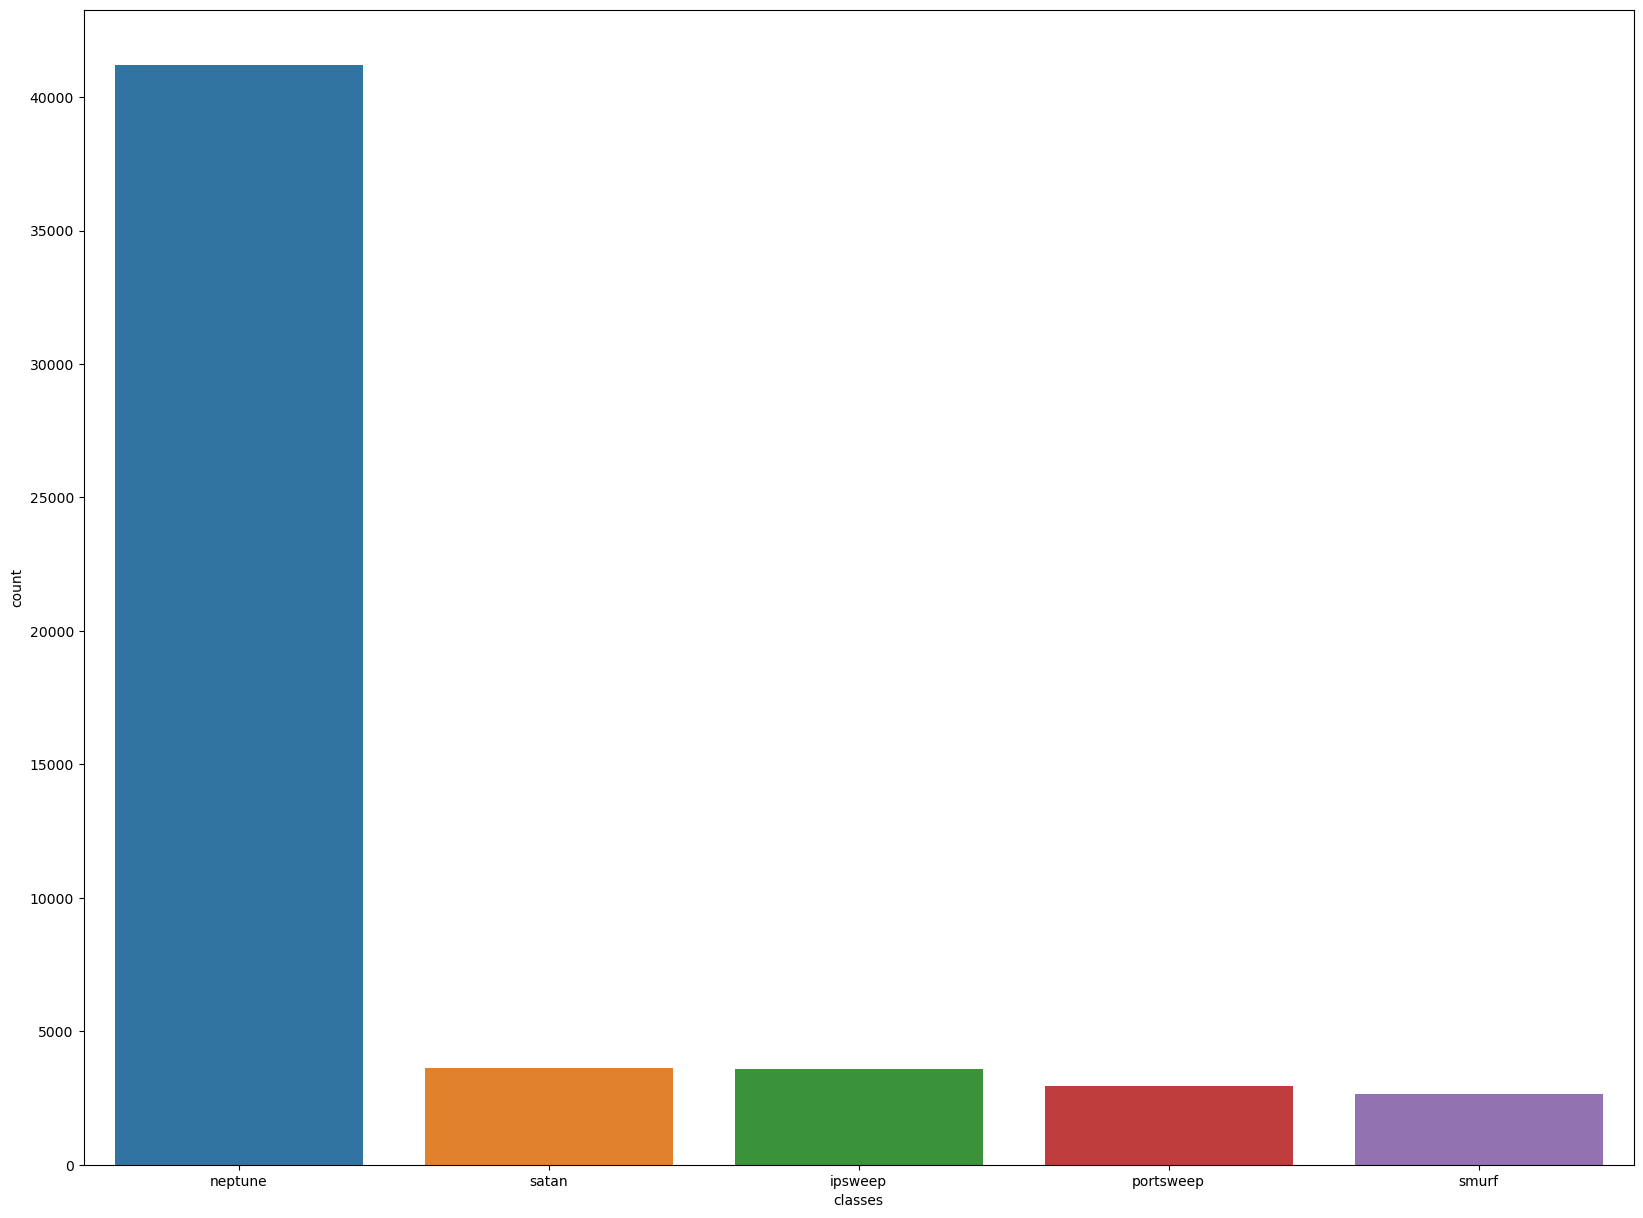

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display

#Visualizing the top 5 most frequent attacks (filtered out 'normal' class to get only attacks).
top_5_dataframes = df.select('classes').where(df.classes != 'normal').groupBy("classes").count().sort("count",ascending=False).limit(5).toPandas()
plt.figure( figsize = ( 20, 15 ) )
sns.barplot( x="classes", y="count", data=top_5_dataframes)
plt.show()

### Q4

In [102]:
# Read the database csv
nfl = spark.read.csv("plays.csv", header=True, inferSchema= True)

In [103]:
# to create a table in postgres with the database.
db_properties={}
#update your db username
db_properties['username']="postgres"
#update your db password
db_properties['password']="bigdata"
#make sure you got the right port number here
db_properties['url']= "jdbc:postgresql://localhost:5432/postgres"
#make sure you had the Postgres JAR file in the right location
db_properties['driver']="org.postgresql.Driver"
db_properties['table']= "Plays"

nfl.write.format("jdbc")\
.mode("overwrite")\
.option("url", db_properties['url'])\
.option("dbtable", db_properties['table'])\
.option("user", db_properties['username'])\
.option("password", db_properties['password'])\
.option("Driver", db_properties['driver'])\
.save()

In [104]:
# Rad back the table from postgres in order to do data cleaning and feature engineering

nfl_read = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()


nfl_read.show(3, vertical=True)

-RECORD 0--------------------------------------
 gameId                 | 2017091004           
 playId                 | 37                   
 quarter                | 1                    
 GameClock              | 2022-10-16 15:00:00  
 down                   | 0                    
 yardsToGo              | 0                    
 possessionTeam         | DET                  
 yardlineSide           | DET                  
 yardlineNumber         | 35                   
 offenseFormation       | NA                   
 personnel.offense      | NA                   
 defendersInTheBox      | NA                   
 numberOfPassRushers    | NA                   
 personnel.defense      | NA                   
 HomeScoreBeforePlay    | 0                    
 VisitorScoreBeforePlay | 0                    
 HomeScoreAfterPlay     | 0                    
 VisitorScoreAfterPlay  | 0                    
 isPenalty              | false                
 isSTPlay               | true          

In [105]:
nfl.printSchema()

root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: timestamp (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- personnel.offense: string (nullable = true)
 |-- defendersInTheBox: string (nullable = true)
 |-- numberOfPassRushers: string (nullable = true)
 |-- personnel.defense: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- KickReturnYardage: s

In [146]:
# Columns that need casting

# GameClock string
# yardlineNumber integer
# numberOfPassRushers integer
# defendersInTheBox integer
# KickReturnYardage integer
# PassLength integer
# YardsAfterCatch integer


casted_types_nfl = (nfl.withColumn("GameClock", nfl.GameClock.cast("String")) \
                    .withColumn("yardlineNumber", nfl.yardlineNumber.cast("Integer")) \
                    .withColumn("numberOfPassRushers", nfl.numberOfPassRushers.cast("Integer")) \
                    .withColumn("defendersInTheBox", nfl.defendersInTheBox.cast("Integer")) \
                    .withColumn("KickReturnYardage", nfl.KickReturnYardage.cast("Integer")) \
                    .withColumn("PassLength", nfl.PassLength.cast("Integer")) \
                    .withColumn("YardsAfterCatch", nfl.YardsAfterCatch.cast("Integer"))
# Columns to renamne (they gave issues when trying to carry out some of the tasks later on)                   )
renamed_nfl = (casted_types_nfl.withColumnRenamed("personnel.offense", "offensePersonnel") \
               .withColumnRenamed("personnel.defense", "defensePersonnel")
              )

In [147]:
renamed_nfl.printSchema()

root
 |-- gameId: integer (nullable = true)
 |-- playId: integer (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- GameClock: string (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- yardlineNumber: integer (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- offensePersonnel: string (nullable = true)
 |-- defendersInTheBox: integer (nullable = true)
 |-- numberOfPassRushers: integer (nullable = true)
 |-- defensePersonnel: string (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- HomeScoreAfterPlay: integer (nullable = true)
 |-- VisitorScoreAfterPlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- SpecialTeamsPlayType: string (nullable = true)
 |-- KickReturnYardage: int

In [148]:
from pyspark.ml.feature import Imputer

# Imputing being done to all the numeric columns.
columns_to_be_imputed = ["quarter", "down", "yardsToGo", "yardlineNumber", "defendersInTheBox", "numberOfPassRushers", "HomeScoreBeforePlay", "VisitorScoreAfterPlay", "KickReturnYardage", "PassLength", "YardsAfterCatch", "PlayResult"]

value_not_in_dataset = -20000

# Replace None/Missing Value with a value that can't be present in the dataset.
nfl_with_filled_na = renamed_nfl.fillna(-20000, columns_to_be_imputed)

#Create new columns with imputed values. New columns will be suffixed with "_imputed"
imputer = Imputer (
            inputCols=columns_to_be_imputed,
            outputCols=["{}_imputed".format(c) for c in columns_to_be_imputed])\
            .setStrategy("median").setMissingValue(value_not_in_dataset)

nfl_imputed = imputer.fit(nfl_with_filled_na).transform(nfl_with_filled_na)
# we will drop the old column without imputation. We have only one column to be imputed
nfl_imputed_enhanced = nfl_imputed.drop("gameId", "playId", "quarter", "down", "yardsToGo", "yardlineNumber", "defendersInTheBox", "numberOfPassRushers", "HomeScoreBeforePlay", "VisitorScoreAfterPlay", "KickReturnYardage", "PassLength", "YardsAfterCatch", "PlayResult")

# We will rename our newly imputed column with the correct name
nfl_fully_imputed = (nfl_imputed_enhanced.withColumnRenamed("gameId_imputed","gameId") \
                     .withColumnRenamed("playId_imputed","playId") \
                     .withColumnRenamed("quarter_imputed","quarter") \
                     .withColumnRenamed("down_imputed","down") \
                     .withColumnRenamed("yardsToGo_imputed","yardsToGo") \
                     .withColumnRenamed("yardlineNumber_imputed","yardlineNumber") \
                     .withColumnRenamed("defendersInTheBox_imputed","defendersInTheBox") \
                     .withColumnRenamed("numberOfPassRushers_imputed","numberOfPassRushers") \
                     .withColumnRenamed("HomeScoreBeforePlay_imputed","HomeScoreBeforePlay") \
                     .withColumnRenamed("VisitorScoreAfterPlay_imputed","VisitorScoreAfterPlay") \
                     .withColumnRenamed("KickReturnYardage_imputed","KickReturnYardage") \
                     .withColumnRenamed("PassLength_imputed","PassLength") \
                     .withColumnRenamed("YardsAfterCatch_imputed","YardsAfterCatch") \
                     .withColumnRenamed("PlayResult_imputed","PlayResult")
                    )
                     

In [140]:
from pyspark.sql.functions import *

# Looking for missing values from the remaining columns =, except the binary ones.
null_counts_plays_df = nfl_fully_imputed.select([count(when(col(c) == 'NA', c)).alias(c) \
                        for c in nfl_fully_imputed.columns if c not in {'isPenalty', 'isSTPlay'}])

null_counts_plays_df.show(truncate=False, vertical=True)
nfl_fully_imputed.count()

-RECORD 0-----------------------
 GameClock              | 180   
 possessionTeam         | 0     
 yardlineSide           | 180   
 offenseFormation       | 2773  
 offensePersonnel       | 2625  
 defensePersonnel       | 2625  
 VisitorScoreBeforePlay | 0     
 HomeScoreAfterPlay     | 0     
 SpecialTeamsPlayType   | 11557 
 PassResult             | 7230  
 playDescription        | 0     
 quarter                | 0     
 down                   | 0     
 yardsToGo              | 0     
 yardlineNumber         | 0     
 defendersInTheBox      | 0     
 numberOfPassRushers    | 0     
 HomeScoreBeforePlay    | 0     
 VisitorScoreAfterPlay  | 0     
 KickReturnYardage      | 0     
 PassLength             | 0     
 YardsAfterCatch        | 0     
 PlayResult             | 0     



14193

In [149]:
# Dropping two columns with over 50% NA values.
nfl_fully_imputed = nfl_fully_imputed.drop("SpecialTeamsPlayType", "PassResult")


In [150]:
# Substituting string "NA" with None type so that null values can be dropped.

missing_value = "NA"
nfl_with_substituted_na = nfl_fully_imputed
for c in {"GameClock", "yardlineSide", "offenseFormation", "offensePersonnel", "defensePersonnel"}:
    nfl_with_substituted_na = (nfl_with_substituted_na\
        .withColumn(c, \
                when(col(c)==missing_value,\
                    regexp_replace(col(c),missing_value,None)) \
                .otherwise(col(c)))
                )

nfl_with_substituted_na.show(1, vertical=True)

-RECORD 0--------------------------------------
 GameClock              | 2022-10-16 15:00:00  
 possessionTeam         | DET                  
 yardlineSide           | DET                  
 offenseFormation       | null                 
 offensePersonnel       | null                 
 defensePersonnel       | null                 
 VisitorScoreBeforePlay | 0                    
 HomeScoreAfterPlay     | 0                    
 isPenalty              | false                
 isSTPlay               | true                 
 playDescription        | K.Redfern kicks 6... 
 quarter                | 1                    
 down                   | 0                    
 yardsToGo              | 0                    
 yardlineNumber         | 35                   
 defendersInTheBox      | 6                    
 numberOfPassRushers    | 4                    
 HomeScoreBeforePlay    | 0                    
 VisitorScoreAfterPlay  | 0                    
 KickReturnYardage      | 23            

In [151]:
# Dropping null values.
nfl_clean = nfl_with_substituted_na.na.drop()

In [152]:
nfl_clean.show(1, vertical=True)
nfl_clean.count()

-RECORD 0--------------------------------------
 GameClock              | 2022-10-16 14:54:00  
 possessionTeam         | ARI                  
 yardlineSide           | ARI                  
 offenseFormation       | SHOTGUN              
 offensePersonnel       | 1 RB, 1 TE, 3 WR     
 defensePersonnel       | 4 DL, 2 LB, 5 DB     
 VisitorScoreBeforePlay | 0                    
 HomeScoreAfterPlay     | 0                    
 isPenalty              | false                
 isSTPlay               | false                
 playDescription        | (14:54) (Shotgun)... 
 quarter                | 1                    
 down                   | 1                    
 yardsToGo              | 10                   
 yardlineNumber         | 23                   
 defendersInTheBox      | 6                    
 numberOfPassRushers    | 4                    
 HomeScoreBeforePlay    | 0                    
 VisitorScoreAfterPlay  | 0                    
 KickReturnYardage      | 13            

11258

Phase II

In [153]:
nfl_clean.summary().show(truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 summary                | count                                                                                                                                                                                                                        
 GameClock              | 11258                                                                                                                                                                                                                        
 possessionTeam         | 11258                                                                                                                                                                                                                        
 yardlin

In [154]:
# To find and handle outliers.

from functools import reduce

def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]
    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',reduce(column_add, ( df[col] for col in  selected_columns)))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [155]:
nfl_with_outlier_handling = find_outliers(nfl_clean)
nfl_with_outlier_handling.show(1, vertical=True)

-RECORD 0--------------------------------------
 GameClock              | 2022-10-16 14:54:00  
 possessionTeam         | ARI                  
 yardlineSide           | ARI                  
 offenseFormation       | SHOTGUN              
 offensePersonnel       | 1 RB, 1 TE, 3 WR     
 defensePersonnel       | 4 DL, 2 LB, 5 DB     
 VisitorScoreBeforePlay | 0                    
 HomeScoreAfterPlay     | 0                    
 isPenalty              | false                
 isSTPlay               | false                
 playDescription        | (14:54) (Shotgun)... 
 quarter                | 1                    
 down                   | 1                    
 yardsToGo              | 10                   
 yardlineNumber         | 23                   
 defendersInTheBox      | 6                    
 numberOfPassRushers    | 4                    
 HomeScoreBeforePlay    | 0                    
 VisitorScoreAfterPlay  | 0                    
 KickReturnYardage      | 13            

In [156]:
nfl_with_outlier_handling.groupby("total_outliers").count().show()

+--------------+-----+
|total_outliers|count|
+--------------+-----+
|             1| 2317|
|             6|    7|
|             3| 1350|
|             5|   31|
|             4|  323|
|             7|    1|
|             2| 2631|
|             0| 4598|
+--------------+-----+



In [157]:
# Dropped rows with more than 4 outliers.
nfl_with_substituted_na_and_outliers = nfl_with_outlier_handling.\
        filter(nfl_with_outlier_handling['total_Outliers']<=4)
print(nfl_with_substituted_na_and_outliers.count())

11219


In [158]:
# looking for correlated features.
correlation_matrix = nfl_with_substituted_na_and_outliers.toPandas().corr()
print(correlation_matrix)

                        VisitorScoreBeforePlay  HomeScoreAfterPlay  isPenalty  \
VisitorScoreBeforePlay                1.000000            0.422827  -0.008363   
HomeScoreAfterPlay                    0.422827            1.000000   0.007358   
isPenalty                            -0.008363            0.007358   1.000000   
isSTPlay                                   NaN                 NaN        NaN   
quarter                               0.688827            0.629390  -0.001668   
down                                 -0.003151           -0.003336   0.025611   
yardsToGo                            -0.006565           -0.023667   0.006349   
yardlineNumber                        0.002474           -0.012736  -0.003311   
defendersInTheBox                    -0.043214           -0.040048  -0.013205   
numberOfPassRushers                  -0.013872            0.004715   0.001650   
HomeScoreBeforePlay                   0.423551            0.996455   0.004926   
VisitorScoreAfterPlay       

In [159]:
# dropping the two columns with high correlation to another column (> 80%)
nfl_with_handled_correlations = nfl_with_substituted_na_and_outliers.drop("VisitorScoreAfterPlay", "HomeScoreAfterPlay")

In [160]:
# Handling Binary columns

nfl_with_handled_binary = (nfl_with_handled_correlations
              .withColumn("isPenalty_encoded", \
                          nfl_with_handled_correlations["isPenalty"].cast("integer")) \
              .withColumn("isSTPlay_encoded", \
                          nfl_with_handled_correlations["isSTPlay"].cast("integer")))
nfl_with_handled_binary.select("isPenalty","isPenalty_encoded").distinct().show()
nfl_with_handled_binary.select("isSTPlay","isSTPlay_encoded").distinct().show()

+---------+-----------------+
|isPenalty|isPenalty_encoded|
+---------+-----------------+
|     true|                1|
|    false|                0|
+---------+-----------------+

+--------+----------------+
|isSTPlay|isSTPlay_encoded|
+--------+----------------+
|   false|               0|
+--------+----------------+



In [161]:
nfl_with_handled_binary.printSchema()

root
 |-- GameClock: string (nullable = true)
 |-- possessionTeam: string (nullable = true)
 |-- yardlineSide: string (nullable = true)
 |-- offenseFormation: string (nullable = true)
 |-- offensePersonnel: string (nullable = true)
 |-- defensePersonnel: string (nullable = true)
 |-- VisitorScoreBeforePlay: integer (nullable = true)
 |-- isPenalty: boolean (nullable = true)
 |-- isSTPlay: boolean (nullable = true)
 |-- playDescription: string (nullable = true)
 |-- quarter: integer (nullable = true)
 |-- down: integer (nullable = true)
 |-- yardsToGo: integer (nullable = true)
 |-- yardlineNumber: integer (nullable = true)
 |-- defendersInTheBox: integer (nullable = true)
 |-- numberOfPassRushers: integer (nullable = true)
 |-- HomeScoreBeforePlay: integer (nullable = true)
 |-- KickReturnYardage: integer (nullable = true)
 |-- PassLength: integer (nullable = true)
 |-- YardsAfterCatch: integer (nullable = true)
 |-- PlayResult: integer (nullable = true)
 |-- total_outliers: integer (n

In [162]:
# Will do one-hot encoding on all string features, since I don't think any of them is ordinal.

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline


# We don't have any ordinal variables. Only nominal variables
# first part : transform the columns to numeric
stage_1 = StringIndexer(inputCol= 'GameClock', outputCol= 'GameClock_index')
stage_2 = StringIndexer(inputCol= 'possessionTeam', outputCol= 'possessionTeam_index')
stage_3 = StringIndexer(inputCol= 'yardlineSide', outputCol= 'yardlineSide_index')
stage_4 = StringIndexer(inputCol= 'offenseFormation', outputCol= 'offenseFormation_index')
stage_5 = StringIndexer(inputCol= 'offensePersonnel', outputCol= 'offensePersonnel_index')
stage_6 = StringIndexer(inputCol= 'defensePersonnel', outputCol= 'defensePersonnel_index')
stage_7 = StringIndexer(inputCol= 'playDescription', outputCol= 'playDescription_index')


# second part : one-hot encode the numeric columns
stage_8= OneHotEncoder(inputCols=["GameClock_index","possessionTeam_index",
                                  "yardlineSide_index","offenseFormation_index", 
                                  "offensePersonnel_index", "defensePersonnel_index", 
                                  "playDescription_index"], 
                        outputCols=['GameClock_encoded','possessionTeam_encoded',
                                   'yardlineSide_encoded','offenseFormation_encoded', 
                                   'offensePersonnel_encoded', 'defensePersonnel_encoded', 
                                    'playDescription_encoded'])

# setup the pipeline
pipeline = Pipeline(stages=[stage_1, stage_2, stage_3, stage_4, stage_5, stage_6, stage_7, stage_8])

# fit the pipeline model and transform the data as defined
pipeline_model = pipeline.fit(nfl_with_handled_binary)
nfl_encoded = pipeline_model.transform(nfl_with_handled_binary)


In [164]:
print(nfl_encoded.select("possessionTeam").distinct().count())

nfl_encoded.select("possessionTeam","possessionTeam_index","possessionTeam_encoded")\
                .distinct().toPandas()

32


,possessionTeam,possessionTeam_index,possessionTeam_encoded
0,TEN,20.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,IND,15.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,HOU,2.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,BAL,11.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,GB,9.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,NYG,14.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,BUF,27.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,NE,1.0,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,ARI,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,TB,25.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [167]:
# Creating feature list without duplicate columns that were encoded previously.
feature_list = nfl_encoded.drop("GameClock","GameClock_index",
                                        "possessionTeam","possessionTeam_index",
                                        "yardlineSide","yardlineSide_index",
                                        "offenseFormation","offenseFormation_index",
                                        "offensePersonnel", "offensePersonnel_index", 
                                        "defensePersonnel", "defensePersonnel_index", 
                                        "playDescription", "playDescription_index").columns
print(feature_list)

['VisitorScoreBeforePlay', 'isPenalty', 'isSTPlay', 'quarter', 'down', 'yardsToGo', 'yardlineNumber', 'defendersInTheBox', 'numberOfPassRushers', 'HomeScoreBeforePlay', 'KickReturnYardage', 'PassLength', 'YardsAfterCatch', 'PlayResult', 'total_outliers', 'isPenalty_encoded', 'isSTPlay_encoded', 'GameClock_encoded', 'possessionTeam_encoded', 'yardlineSide_encoded', 'offenseFormation_encoded', 'offensePersonnel_encoded', 'defensePersonnel_encoded', 'playDescription_encoded']


In [168]:
# Vector Assembly
from pyspark.ml.feature import VectorAssembler


vector_assembler = VectorAssembler(
    inputCols=feature_list, 
    outputCol="vectorized_features")

nfl_with_assembled_features = vector_assembler.transform(nfl_encoded)

In [169]:
# Data Scaling
from pyspark.ml.feature import StandardScaler
standard_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
scaled_model = standard_scaler.fit(nfl_with_assembled_features)
nfl_with_scaled_features = scaled_model.transform(nfl_with_assembled_features)

22/10/16 21:29:13 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/10/16 21:29:14 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
